# ART - Adversarial Patch - TensorFlow v2

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
print(tf.__version__)

2.3.0


# Settings

In [4]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 1
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

# Model definition

In [5]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], 1), zoo_Adam= True)

# Imagenet training images

In [6]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [7]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

# Adversarial patch generation

In [8]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

 98%|███████████████████████████████████████ | 500/512 [03:38<00:05,  2.29it/s]


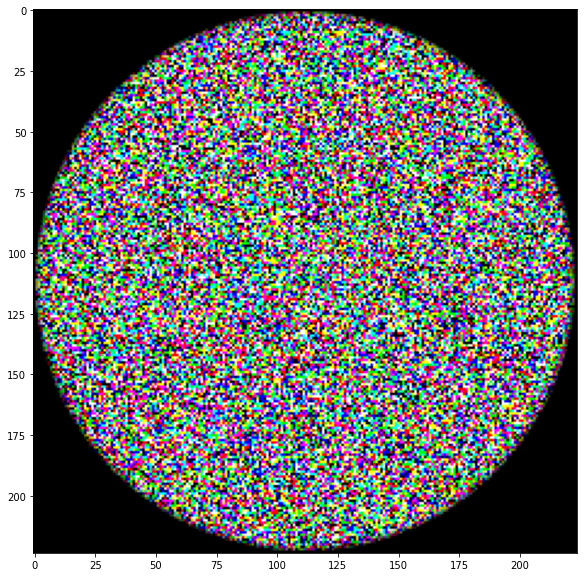

In [9]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

# Evaluation

In [10]:
patched_images = ap.apply_patch(images, scale=0.5)

In [11]:
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

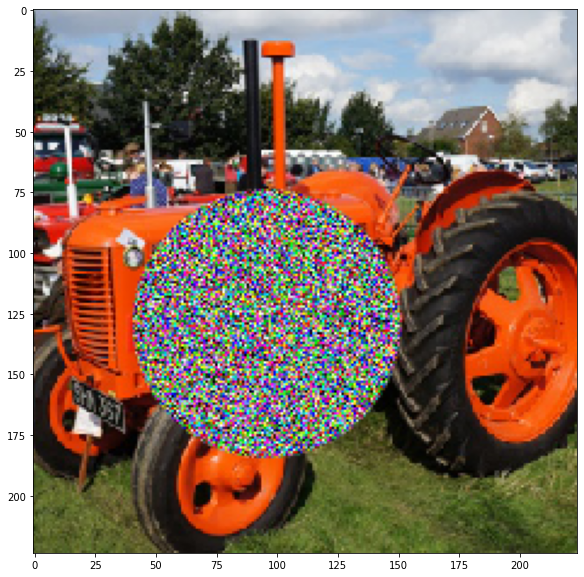

Predictions:
tractor    0.95
thresher   0.02
plow       0.02
harvester  0.01
lawn_mower 0.00


In [12]:
predict_model(tfc, patched_images[0])

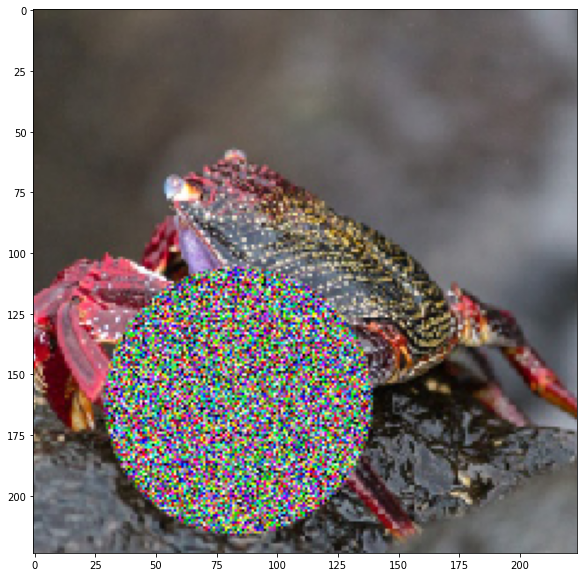

Predictions:
rock_crab   0.96
hip         0.01
brassiere   0.00
brain_coral 0.00
purse       0.00


In [13]:
predict_model(tfc, patched_images[1])

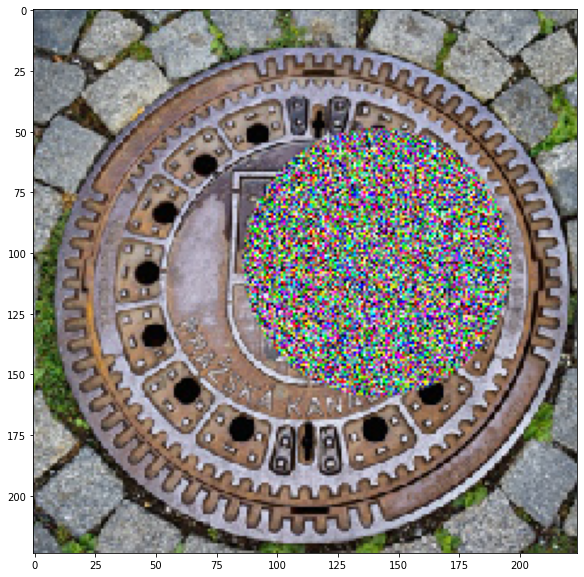

Predictions:
manhole_cover 1.00
brass         0.00
sundial       0.00
bottlecap     0.00
tray          0.00


In [14]:
predict_model(tfc, patched_images[2])